In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util
from google import genai
import time

RESULT_FILE="results.csv"

embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
with open('gemini_key3.txt', 'r') as f:
    client = genai.Client(api_key=f.readline())
model = 'gemini-2.0-flash'

with open('prompts/instructions.txt','r') as file:
	prompt_instructions = file.read()

with open('prompts/template.txt','r') as file:
	prompt_template = file.read()

with open('prompts/persona_pattern.txt','r') as file:
	prompt_persona_pattern = file.read()
      
def create_prompt(course_name: str, course_content: str, nr_of_shots:int, with_expert_pattern:bool):
    prompt_shots = []
    for idx in range(1,nr_of_shots+1):
        with open(f'prompts/shot_{idx}.txt','r') as file:
            prompt_shots.append(file.read())
    persona_pattern = prompt_persona_pattern if with_expert_pattern else ""
    return persona_pattern + prompt_instructions + "\n".join(prompt_shots) + prompt_template.replace("<course_name>", course_name).replace("<course_content>", course_content)

def normalize_concepts(concept_str):
    if isinstance(concept_str, str):
        return [c.strip().lower() for c in concept_str.split(';') if c.strip()]
    else:
        return []

def semantic_match(gt_concepts, gen_concepts, threshold=0.7):
    # Encode all phrases
    gt_embeddings = embedding_model.encode(gt_concepts, convert_to_tensor=True)
    gen_embeddings = embedding_model.encode(gen_concepts, convert_to_tensor=True)

    matches = []
    unmatched_gt = []
    unmatched_gen = set(range(len(gen_concepts)))  # index tracking

    for i, gt_emb in enumerate(gt_embeddings):
        similarities = util.cos_sim(gt_emb, gen_embeddings)[0]
        best_idx = int(similarities.argmax())
        best_score = float(similarities[best_idx])

        if best_score >= threshold and best_idx in unmatched_gen:
            matches.append((gt_concepts[i], gen_concepts[best_idx], best_score))
            unmatched_gen.remove(best_idx)
        else:
            unmatched_gt.append(gt_concepts[i])

    unmatched_gen_phrases = [gen_concepts[i] for i in unmatched_gen]

    return {
        "matches": matches,
        "missing_gt": unmatched_gt,
        "additional_gen": unmatched_gen_phrases
    }

def get_metrics(nr_of_shots:int, with_expert_pattern:bool, gt_file="gt.csv"):
	df = pd.read_csv(gt_file, index_col=0)
	cum_time = 0
	TP = 0
	FP = 0
	FN = 0
	nr_of_examples = len(df.index)

	for _, row in df.iterrows():
		course_name, course_content = row['course_name'], row['program_content']
		isOk = False # in case of exceeding quota limits
		while isOk == False:
			try:
				start = time.time()
				prompt=create_prompt(course_name, course_content, nr_of_shots, with_expert_pattern)
				response = client.models.generate_content(
							model=model,
							contents=prompt,
				)
				cum_time += time.time() - start
				isOk = True

				gt_list = normalize_concepts(row['educational_concepts'])
				gen_list = normalize_concepts(response.text)
						
				res = semantic_match(gt_list, gen_list, 0.7)
				TP += len(res['matches'])
				FP += len(res['additional_gen'])
				FN += len(res['missing_gt'])
				time.sleep(3)
                        
				
			except Exception as e:
				print(e)
				time.sleep(30)
			
	avg_time = cum_time/nr_of_examples
	precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
	recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
	f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
	return precision, recall, f1, avg_time

def experiment( nr_of_shots:int, with_expert_pattern:bool, reps=10):
 for _ in range(reps):
		p, r, f1, t = get_metrics(nr_of_shots, with_expert_pattern)
		line=f"{nr_of_shots},{int(with_expert_pattern)},{p:.2f},{r:.2f},{f1:.2f},{t:.2f}"
		with open(RESULT_FILE,'a') as file:
			file.write(line)
			file.write('\n')

In [ ]:
# example experiment
experiment(nr_of_shots=3, with_expert_pattern=True, reps=30)

429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.0-flash'}, 'quotaValue': '15'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '47s'}]}}
429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For mor

All experiments are saved to: `RESULT_FILE`

Monitor usage of gemini API: [link](https://console.cloud.google.com/apis/api/generativelanguage.googleapis.com)

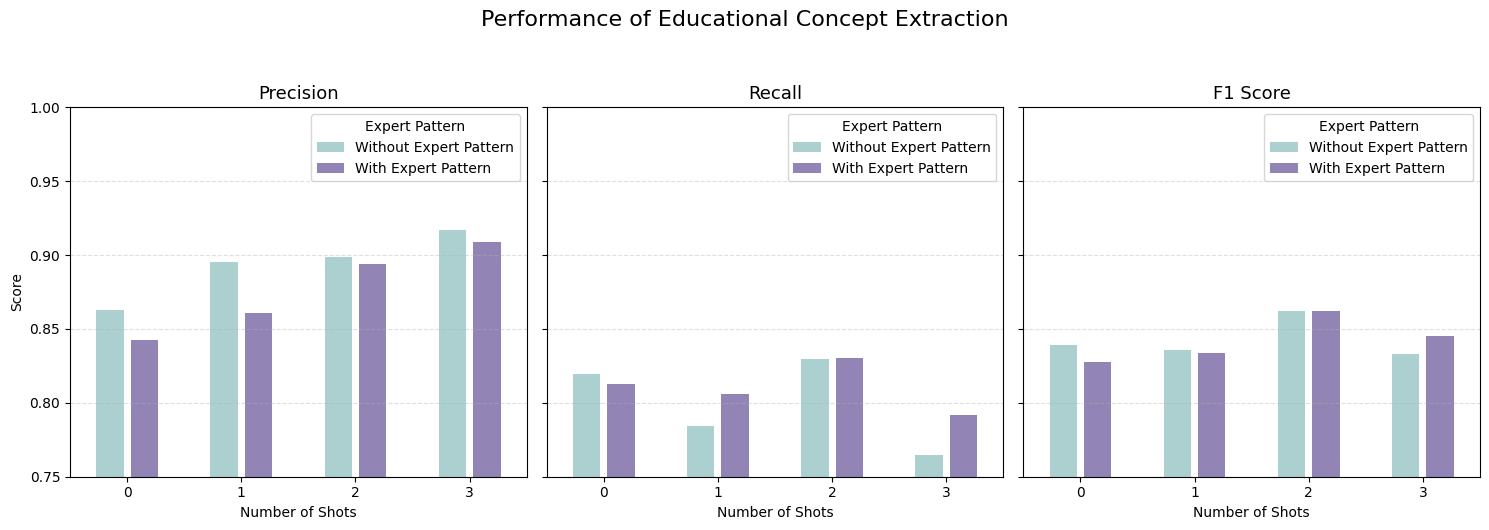

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("results.csv")
df_grouped = df.groupby(["nr_of_shots", "expert_pattern"]).mean().reset_index()
df_grouped["Expert Pattern"] = df_grouped["expert_pattern"].map({0: "Without Expert Pattern", 1: "With Expert Pattern"})

palette = {"With Expert Pattern": "#8E7DBE", "Without Expert Pattern": "#A6D6D6"}

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

metrics = ["precision", "recall", "f1"]
titles = ["Precision", "Recall", "F1 Score"]

for ax, metric, title in zip(axes, metrics, titles):
    sns.barplot(
        data=df_grouped,
        x="nr_of_shots",
        y=metric,
        hue="Expert Pattern",
        palette=palette,
        ax=ax,
        width=0.6,
        gap=0.2
    )
    ax.set_title(f"{title}", fontsize=13)
    ax.set_xlabel("Number of Shots")
    ax.set_ylabel("Score" if metric == "precision" else "")
    ax.set_ylim(0.75, 1.0)
    ax.grid(True, axis='y', linestyle='--', alpha=0.4)

handles, labels = axes[0].get_legend_handles_labels()

plt.suptitle("Performance of Educational Concept Extraction", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()